In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("proj1.ipynb")

# Project 1 - SQL
## Due Date: Thursday, September 21st, 5:00pm

In this project, we will be working with SQL on the IMDB database.

## Objectives

- Explore and extract relevant information from database with SQL functions
- Perform data cleaning and transformation using string functions and regex
- Use the cleaned data to run insightful analysis using joins, aggregations, and window functions

**Note:** If at any point during the project, the internal state of the database or its tables have been modified in an undesirable way (i.e. a modification not resulting from the instructions of a question), restart your kernel, clear output, and simply re-run the notebook as normal. This will shutdown your current connection to the database, which will prevent the issue of multiple connections to the database at any given point. When re-running the notebook, you will create a fresh database based on the provided Postgres dump.

## Logistics & Scoring Breakdown

Each coding question has **both public tests and hidden tests**. Roughly 50% of your grade will be made up of your score on the public tests released to you, while the remaining 50% will be made up of unreleased hidden tests. In addition, there are two free-response questions that will be manually graded.

This is an **individual project**. However, you’re welcome to collaborate with any other student in the class as long as it’s within the [academic honesty guidelines](https://fa23.data101.org/syllabus/#collaboration-and-integrity). Create new cells as needed to acknowledge others.

|Question|Points|
|---|---|
|0|1|
|1a|1|
|1b|2|
|1c|1|
|1d|1|
|2a|1|
|2b|3|
|2c|3|
|3a|2|
|3b|2|
|3c|2|
|3d|1|
|4a|2|
|4b|2|
|4c|1|
|5|2|
|**Total**|27|

In [2]:
# Run this cell to set up imports
import numpy as np
import pandas as pd

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Before You Start: Assignment Tips

<div class="alert alert-block alert-info">
<p><b>Please Read!!</b> In this project we will assume you have attended lecture and seen how to connect to a Postgres server via two ways: JupySQL in Jupyter Notebook, and the psql command-line program.</p>
</div>
    
We have written up these instructions for you in the <a href="https://fa23.data101.org/resources/assignment-tips/">Fall 2023 Assignment Tips</a>—a handy resource that has many other tips:

* PostgreSQL documentation
* JupySQL and magic commands in Jupyter
* JupyterHub keyboard shortcuts
* psql and common meta-commands
* Debugging:
    * Where to create new cells to play nice with the autograder
    * Opening/closing connections, deleting databases if all else fails
* Local installation (not supported by staff officially, but for your reference)



For some questions with multi-line cell magic, we will also be saving the literal query string with [query snippets](https://jupysql.ploomber.io/en/latest/api/magic-snippets.html) using `--save`:

``%%sql --save query result << select * FROM table ...``

# Database Setup
We are going to be using the `JupySQL` library to connect our notebook to a PostgreSQL database server on your JupyterHub account. Running the next cell will do so; you should not see any error messages after it executes.

In [3]:
# The first time you are running this cell, you may need to run the following line as: %load_ext sql 
%reload_ext sql

There's a new jupysql version available (0.10.1), you're running 0.10.0. To upgrade: pip install jupysql --upgrade


In the next cell, we will unzip the data. This only needs to be done once.

In [4]:
!unzip -u data/imdbdb.zip -d data/

Archive:  data/imdbdb.zip


<br/>

**Create the `imdb` database**: <br>
We will use PostgreSQL commands to create a database and import our data into it. Run the following cell to do this.
* You can also run these cells in the command-line via `psql`.
* If you run into the **role does not exist** error, feel free to ignore it. It does not affect data import.

In [5]:
!psql postgresql://jovyan@127.0.0.1:5432/imdb -c 'SELECT pg_terminate_backend(pg_stat_activity.pid) FROM pg_stat_activity WHERE datname = current_database()  AND pid <> pg_backend_pid();'
!psql postgresql://jovyan@127.0.0.1:5432/postgres -c 'DROP DATABASE IF EXISTS imdb'
!psql postgresql://jovyan@127.0.0.1:5432/postgres -c 'CREATE DATABASE imdb'
!psql postgresql://jovyan@127.0.0.1:5432/imdb -f data/imdbdb.sql

 pg_terminate_backend 
----------------------
(0 rows)

DROP DATABASE
CREATE DATABASE
SET
SET
SET
SET
SET
 set_config 
------------
 
(1 row)

SET
SET
SET
SET
SET
SET
CREATE TABLE
ALTER TABLE
CREATE TABLE
ALTER TABLE
CREATE TABLE
ALTER TABLE
CREATE TABLE
ALTER TABLE
CREATE TABLE
ALTER TABLE
CREATE TABLE
ALTER TABLE
COPY 500000
COPY 3804162
COPY 113
COPY 2433431
COPY 337179
COPY 12
ALTER TABLE
ALTER TABLE


**Connect to `imdb` database in the Notebook**: 
<br>
Now let's connect to the new database we just created! There should be no errors after running the following cell.

In [6]:
%sql postgresql://jovyan@127.0.0.1:5432/imdb

**Connect to `imdb` database in `psql`**: 

<div class="alert alert-block alert-info">
<b>Do the following in a Terminal window!</b>
</div>

Connect to the same database via `psql`. See the [Fall 2023 Assignment Tips](https://fa23.data101.org/resources/assignment-tips/) website resource for details on connecting. Run the following meta-command in the `psql` client:

``
\l
``

This should display all databases on this server, including the `imdb` database you just created.


---

**Quick check**: To make sure things are working, let's fetch 10 rows from one of our tables `cast_sample`. Just run the following cell, no further action is needed.

In [7]:
%%sql
SELECT * 
  FROM cast_sample
LIMIT 10

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

id,person_id,movie_id,role_id
708,235,2345369,1
721,241,2504309,1
789,264,2156734,1
875,299,1954994,1
888,302,765037,1
889,302,765172,1
898,306,291387,1
899,306,1477434,1
931,324,824119,1
1936,543,1754068,1


## Connect to the grader

In [8]:
# Connecting the grader
# Just run the following cell, no further action is needed.
from data101_utils import GradingUtil
grading_util = GradingUtil("proj1")
grading_util.prepare_autograder()

## The `imdb` Database

In this project, we are working with a reduced version of the Internet Movie Database (IMDb) database. This Postgres database is a small random sample of actors from the much larger full database (which is over several GBs large) and includes their corresponding movies and cast info. Disclaimer: as a result, we may obtain wildly  different results than if we were to use the entire database. 

- **actor_sample**: information about the actors including id, name, and gender
- **cast_sample**: each person on the cast of each movie gets a row including cast id, each person's id (`actor_sample.id`), movie id (`movie_sample.id`), and role id
- **movie_sample**: sample of movies the actors have been in, including movie id, title, and the production year
- **movie_info_sample**: this table originally had a lot of information for each movie (take a look at info_type to see the information available), but we have dropped some information to make it easier to manage. This table includes movie info's id, movie id, info type id, and the info itself
- **info_type**: reference table to match each info type id to the description of the type of information
- **role_type**: reference table for cast_sample to match role id to the description of the role

### Key Notes
- This database is **not** the same as the IMDb lecture database, but has a lot of of similar features. 
- Point of confusion: `movie_sample` and `actor_sample` both have attributes `id` corresponding to 7 digit unique numeric identifiers, but do **not** refer to the same data values.
- `cast_sample` is analagous to the `crew` table from lecture. It can be used to match an actor's id to movies they have acted in, among other relations.
- You are highly encouraged to spend some time exploring the metadata of these tables using Postgres meta-commands to better understand the data given and the relations between tables.

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />

# The `information_schema` schema

A **schema** is a namespace of tables in the database, often used for security purposes. Let's see how many schema are defined for us in our current database:


In [9]:
%%sql
SELECT * 
FROM information_schema.schemata;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

4 rows affected.

catalog_name,schema_name,schema_owner,default_character_set_catalog,default_character_set_schema,default_character_set_name,sql_path
imdb,pg_toast,jovyan,None,None,None,None
imdb,pg_catalog,jovyan,None,None,None,None
imdb,public,jovyan,None,None,None,None
imdb,information_schema,jovyan,None,None,None,None


Within a Postgres database, there are often at least three schemas:
* `public`, a public schema that users can access and create tables in;
* `pg_catalog`, a schema for maintaining system information; and
* `information_schema`, a schema that maintains metadata about objects currently created in the database.
* The fourth schema `pg_toast` maintains data that can't regularly be stored in relations, such as very large data values. See more in documentation [here](https://www.postgresql.org/docs/current/storage-toast.html).

For now, we focus on the `information_schema` schemata, which stores our metadata. That’s right—metadata is also data, and as we make updates to our `public` databases, metadata is automatically stored and updated into different tables under the `information_schema` schema.

There are many metadata tables that Postgres updates for us, and the full list is in the Postgres documentation [(Chapter 37)](https://www.postgresql.org/docs/current/information-schema.html). 
For now, let’s look at which the `.tables` table ([37.54](https://www.postgresql.org/docs/current/infoschema-tables.html)), which lists all the tables located in the database. Let’s specifically look at those that are in the public schema (i.e., publicly accessible tables):

In [10]:
%%sql
SELECT * 
FROM information_schema.tables
WHERE table_schema = 'public';

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

6 rows affected.

table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
imdb,public,actor_sample,BASE TABLE,None,None,None,None,None,YES,NO,None
imdb,public,cast_sample,BASE TABLE,None,None,None,None,None,YES,NO,None
imdb,public,info_type,BASE TABLE,None,None,None,None,None,YES,NO,None
imdb,public,movie_info_sample,BASE TABLE,None,None,None,None,None,YES,NO,None
imdb,public,movie_sample,BASE TABLE,None,None,None,None,None,YES,NO,None
imdb,public,role_type,BASE TABLE,None,None,None,None,None,YES,NO,None


<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />


# Question 0


As stated above, there are many metadata tables stored in the `information_schema` schema. Write a query that returns the names of all relations in the PostgreSQL `information_schema` schema, i.e., the names of all the metadata tables

**Hints:**
* Your resulting table names should correspond to what’s listed in the information schema documentation [(Chapter 37)](https://www.postgresql.org/docs/15/information-schema.html). 
* For you to think about: Why might there be fewer tables in your query response than the full list in the documentation? 

In [11]:
%%sql --save query_0 result_0 <<
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'information_schema';

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

69 rows affected.

In [12]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_0 = %sqlcmd snippets query_0
grading_util.save_results("result_0", query_0, result_0)
result_0

table_name
information_schema_catalog_name
attributes
applicable_roles
administrable_role_authorizations
check_constraint_routine_usage
character_sets
check_constraints
collations
collation_character_set_applicability
column_column_usage


In [13]:
grader.check("q0")

q0 results: All test cases passed!

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />


# Question 1: Exploratory Data Analysis
One of the first things you'll want to do with a database table is get a sense for its metadata: column names and types, and number of rows. 

## Tutorial 

We can use the PostgreSQL `\d` meta-command to get a description of all the columns in the `movie_info_sample` table. Open up a terminal window, connect to the imdb server, and analyze the output of the meta-command:

``\d movie_info_sample``

We can use the PostgreSQL `\d` meta-command to get a description the `movie_info_sample` schema. Open up a terminal window, connect to the imdb server, and analyze the output of the meta-command:

``\d movie_info_sample``

There are four attributes in this schema, of which `"id"` is one. What are the other attribute names? Assign `result_1a` to a list of strings, where each element is an attribute name. The list does not need to be in order.

In [14]:
result_1a = ["id", 'movie_id', 'info_type_id', 'info']
result_1a

['id', 'movie_id', 'info_type_id', 'info']

In [15]:
grader.check("q1a")

q1a results: All test cases passed!

**Debugging tip**: Throughout this project and when working with databases, you should always be checking schemas via the `\d` psql metacommand.

<br><br>

---

## Question 1b

Next, let’s continue with our initial exploration of this table. How many rows are in this table? 

Assign `result_1b` to the result of a SQL query to calculate the number of rows in the `movie_info_sample` table. Then, assign `count_1b` to the integer number of rows based on what you found in `result_1b`. Do not hard code this value.

**Hints:**
- See the [Assignment Tips](https://fa23.data101.org/resources/assignment-tips/) page for how to use SQL line magic.
- Your query result should have exactly one row and one attribute; the lone value in the instance should be the number of rows.
- See the `JupySQL` [documentation](https://jupysql.ploomber.io/en/latest/intro.html) for how to index into a SQL query result.

In [16]:
result_1b = %sql SELECT COUNT(*) FROM movie_info_sample;
count_1b = result_1b[0][0]

# do not edit below this line
display(result_1b)
count_1b

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

1 rows affected.

count
2433431


2433431

In [17]:
grader.check("q1b")

q1b results: All test cases passed!

<br><br>

---

## Question 1c: Random table sample

Now that we know a bit about the metadata of the table, let's randomly sample rows from `movie_info_sample` to explore its contents.

Given that you know the size of the table from the previous query, **write a query that retrieves 5 tuples on expectation using the `BERNOULLI` sampling method.** That is, if we run the query multiple times, we should get 5 tuples on average in our resulting table. The `BERNOULLI` sampling method scans the whole table and selects individual rows independently with `p%` probability. Please see the [documentation](https://www.postgresql.org/docs/15/sql-select.html) for syntax.


**Hints/Details:**
* Assign `p_1c` to a sampling rate that you pass into the `query_1c` f-string using Python variable substitution. Your formula should contain `count_1b`. Don't forget to express `p_1c` in units of percent, i.e., `p_1c = 0.03` is 0.03%!
* For a refresher on f-strings and Python variable substitution, see [this tutorial](https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/). If Python variable substitution is done correctly, we should be able to change our `p%` probability by simply reassigning `p_1c` and rerunning the query. (Please leave `p_1c` unchanged.)
* We have completed the SQL line magic for you; this references the Python f-string `query_1c` you created within a SQL query using JupySQL-specific syntax.
* Try running the SQL cell many times and see what you notice.

In [18]:
p_1c = (5 / count_1b) * 100
query_1c = f"SELECT * FROM movie_info_sample TABLESAMPLE BERNOULLI({p_1c})" # edit this query string

# Do not edit below this line
result_1c = %sql {{query_1c}}

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

7 rows affected.

In [19]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
grading_util.save_results("result_1c", query_1c, result_1c)
result_1c

id,movie_id,info_type_id,info
5258377,2309277,8,USA
6247435,2046319,3,War
9733792,2451139,1,92
9383391,1913313,1,Switzerland:90
9056495,572040,1,50
9612216,2263957,1,USA:44
5847178,1781517,3,Drama


In [20]:
grader.check("q1c")

q1c results: All test cases passed!

<br><br>

---

## Question 1d: Random sample, fixed number of rows

If a random number of rows is not of importance, a more efficient way to get some arbitrary tuples from a table is to use the `ORDER BY` and `LIMIT` clauses. In the next cell, fetch 5 **random** tuples from `movie_info_sample`. Compared to the previous question, your query result here should always have 5 tuples!

**Hint**: Check out lecture.


In [21]:
%%sql --save query_1d result_1d <<
SELECT *
FROM movie_info_sample
ORDER BY RANDOM()
LIMIT 5;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

5 rows affected.

In [22]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_1d = %sqlcmd snippets query_1d
grading_util.save_results("result_1d", query_1d, result_1d)
result_1d

id,movie_id,info_type_id,info
4235702,316583,8,Belgium
1394986,2267238,106,"€ 120,347 (Italy) (9 May 2004) (150 screens)"
9109174,984059,1,2
5930700,1838236,3,Drama
4260341,438869,8,USA


In [23]:
grader.check("q1d")

q1d results: All test cases passed!

<br/><br/><br/>
<hr style="border: 1px solid #fdb515;" />


# Question 2: Data Cleaning

The `movie_sample` table contains a very minimal amount of information per movie:

In [24]:
%sql SELECT * FROM movie_sample LIMIT 5;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

5 rows affected.

id,title,production_year
2038405,La corte de faraón,1944
2081186,Long de xin,1985
2177749,Onésime aime les bêtes,1913
1718608,Bedtime Worries,1933
2130699,Mothman,2000


In this question, we’re going to create a nice, refined view of the `movie_sample` table that also includes a **rating field**, called `movie_ratings`.

The [MPAA rating](https://www.motionpictures.org/film-ratings/) is commonly included in most datasets about movies, including ours, but in its current format in the dataset, it’s quite difficult to extract.

The first clue about our approach comes from the random rows you explored in Question 1. As you saw, the `movie_info_sample` table contains a lot of information about each movie. Each row contains a particular type of information (e.g., runtime, languages) categorized by `info_type_id`. Based on the other tables in this database, the `info_type` table is a reference table to this 
ID number.

Our strategy in this question is therefore as follows:
* **Question 2a**: Find the `mpaa_rating_id` from the `info_type` table.
* **Question 2b**: Extract the MPAA rating of a specific movie from the `movie_info_sample` table.
* **Question 2c**: Construct a view `movie_ratings` based on the `movie_sample` table and all relevant MPAA ratings extracted from the `movie_info_sample` table.

<br><br>

---

## Question 2a: MPAA Rating and `info_type`

To start, using the `info_type` table, write a query to find which `id` corresponds to a film's MPAA rating.  The query `result_2a` that you write should return a relation with exactly one row and one attribute; the lone value in the instance should be the MPAA rating id number. We've then assigned `mpaa_rating_id` to extract the number itself from the relation.

**Hints:** 
- Open the `psql` client in a terminal to explore the schema of `info_type` via the `\d` metacommand (see the [Assignment Tips](https://fa23.data101.org/resources/assignment-tips/) page). Remember you can also write SQL commands to that terminal to interact with the IMDB database, but all final work must be submitted through this Jupyter Notebook.
- Be careful when using quotes. SQL interprets single and double quotes differently. The single quote character `'` is reserved for delimiting string constants, while the double quote `"` is used for naming tables or columns that require special characters. See [documentation](https://www.postgresql.org/docs/current/sql-syntax-lexical.html) for more.

In [25]:
result_2a = %sql SELECT id FROM info_type WHERE info LIKE 'mpaa';
mpaa_rating_id = result_2a[0][0]

# do not edit below this line
display(result_2a)
mpaa_rating_id

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

1 rows affected.

id
97


97

In [26]:
grader.check("q2a")

q2a results: All test cases passed!

<br><br>

---

## Question 2b: Looking up the MPAA Rating

Suppose we wanted to find the MPAA rating for the 2004 American teen drama classic, _Mean Girls_. The below cell assigns `movie_id_2b` to the IMDb ID of this movie, 2109683.

In [27]:
# Just run this cell, no further action is needed.
movie_id_2b = 2109683
%sql SELECT * FROM movie_sample WHERE id = {{movie_id_2b}};

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

1 rows affected.

id,title,production_year
2109683,Mean Girls,2004


In the next cell, **write a query to find the MPAA rating for this movie.** Your query should return a relation with exactly one row , which has `(info, mpaa_rating)`, where `info` is the full MPAA rating string from `movie_info_sample`, and `mpaa_rating` is just the rating itself (i.e. `R`, `PG-13`, `PG`, etc) for this movie.


**Before you get started**:
* Explore the `movie_info_sample` tuples corresponding to the MPAA rating by using metacommands in the terminal. The `info` field is a little longer than just the rating. It also includes an explanation for why that movie received its rating. 
* You will need to extract a substring from the `info` column of `movie_info_sample`; you can use the [string functions](https://www.postgresql.org/docs/current/functions-string.html) in PostgreSQL to do it. There are many possible solutions. One possible solution is to use the substring function along with regex. If you use this approach, [this section on regex](https://www.postgresql.org/docs/current/functions-matching.html#FUNCTIONS-POSIX-REGEXP) may be particularly useful. [regex101.com](https://regex101.com) may also be helpful to craft your regular expressions.
* You may use `mpaa_rating_id` and `movie_id_2b` directly in the rest of the questions using Python variable substitution (i.e., double curly braces). See the `JupySQL` documentation for more details.

In [28]:
%%sql --save query_2b result_2b << 
SELECT info, SUBSTRING(info, 'Rated ([\S]+)') AS mpaa_rating
FROM movie_info_sample AS mis
WHERE mis.info_type_id = {{mpaa_rating_id}} AND mis.movie_id = {{movie_id_2b}}

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

1 rows affected.

In [29]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_2b = %sqlcmd snippets query_2b
grading_util.save_results("result_2b", query_2b, result_2b)
result_2b

info,mpaa_rating
"Rated PG-13 for sexual content, language and some teen partying",PG-13


In [30]:
grader.check("q2b")

q2b results: All test cases passed!

You may use `mpaa_rating_id` directly in the rest of the questions using python variable substitution.

<br><br>

---

## Question 2c
In the next cell,
1. Construct a view named `movie_ratings` containing one row for each movie, which has `(movie_id, title, info, mpaa_rating)`, where `info` is the full MPAA rating string from `movie_info_sample`, and `mpaa_rating` is just the rating itself (i.e. `R`, `PG-13`, `PG`, etc).
    * In other words, extend `movie_sample` with the MPAA rating attributes that you found in the previous question part, but this time for all movies.
2. Following the view definition, also write a `SELECT` query to return the **first 20 rows** of the view, ordered by ascending `movie_id`.

In [31]:
%%sql --save query_2c result_2c << 
DROP VIEW IF EXISTS movie_ratings;
CREATE VIEW movie_ratings AS (
    SELECT movie_sample.id AS movie_id, title, info, SUBSTRING(info, 'Rated ([\S]+)') AS mpaa_rating
    FROM movie_sample
    INNER JOIN movie_info_sample AS mis ON mis.movie_id = movie_sample.id
    WHERE mis.info_type_id = {{mpaa_rating_id}}
);

SELECT *
FROM movie_ratings
ORDER BY movie_id ASC
LIMIT 20;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

20 rows affected.

In [32]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_2c = %sqlcmd snippets query_2c
grading_util.save_results("result_2c", query_2c, result_2c)
result_2c

movie_id,title,info,mpaa_rating
1632926,$5 a Day,"Rated PG-13 for sexual content, brief nudity and language",PG-13
1632941,$9.99,Rated R for language and brief sexuality and nudity,R
1632956,$windle,Rated R for some violence and brief sexuality/nudity,R
1633013,'A' gai wak,Rated PG-13 for violence,PG-13
1633014,'A' gai wak juk jap,Rated PG-13 for violence,PG-13
1633461,'R Xmas,"Rated R for strong language, drug content and some violence",R
1633618,'Til There Was You,"Rated PG-13 for sensuality, language and drug references",PG-13
1633729,(500) Days of Summer,Rated PG-13 for sexual material and language,PG-13
1633856,(Untitled),Rated R for language and nude images,R
1634282,.45,"Rated R for pervasive strong language including graphic sexual references, violence, sexuality and some drug use",R


In [33]:
grader.check("q2c")

q2c results: All test cases passed!

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />

# Question 3: Movie Moola
One measure of a movie's success is how much money it makes. If we look at our `info_type` table, we have information about the film's gross earnings and the budget for a film. It would be nice to know how much money a film made using the profit formula:
$$profit = earnings - moneyspent$$

We start by taking a look at the gross info type, with `info_type_id = 107`.

In [34]:
%%sql
SELECT * 
FROM movie_info_sample
WHERE info_type_id = 107
ORDER BY id
LIMIT 10 OFFSET 100000;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

id,movie_id,info_type_id,info
1464348,2281091,107,"INR 23,373,000 (India) (25 February 2005)"
1464349,2281091,107,"INR 19,207,000 (India) (18 February 2005)"
1464374,1766950,107,"HKD 826,364 (Hong Kong) (11 December 1975)"
1464375,1769023,107,"HKD 3,148,549 (Hong Kong) (19 November 1980)"
1464378,1799099,107,"HKD 6,493,694 (Hong Kong) (22 December 1981)"
1464383,1847670,107,"$21,438 (USA) (9 August 2009)"
1464384,1847670,107,"$10,266 (USA) (2 August 2009)"
1464396,1916002,107,"$5,932 (USA) (27 November 2005)"
1464397,1916002,107,"$4,206 (USA) (20 November 2005)"
1464398,1916002,107,"$2,939 (USA) (23 October 2005)"


There are a lot of things to notice here. First of all, the values in the `info` attribute are strings with not only the earnings, but also the country and the month the earnings are cummulatively summed until. Additionally, the info values are not all in the same currency! On top of that, it appears as if some of the gross earnings, even for those in USD are from worldwide sales, while others only count sales within the USA.

For consistency, let's only use movies with gross earnings counted in the USA and that are in US Dollars ($). 

<br><br>

---

## Question 3a: Earnings
We want the numerical part of the `info` column and the **maximum earnings value** for a particular film. 

In the next cell,
- Construct a view named `movie_gross` containing one row for each movie, which has `(gross, movie_id, title)`, where `gross` is the numeric dollar amount extracted as a float.
- To take a look at our cleaned data, write a `SELECT` query to display the **top 10 highest grossing films** from `movie_gross`.

**Hints:** 
- The way we extracted the MPAA rating is very similar to how we want to isolate the numeric dollar amount as a string. (There are multiple ways of doing this.)
- Look at the [documentation](https://www.postgresql.org/docs/9.4/functions-matching.html) for the `regexp_replace` function, and specifically 'flag g'.
- The staff solution found it helpful to make an additional subview.

In [35]:
%%sql --save query_3a result_3a <<

DROP VIEW IF EXISTS movie_gross;
    
CREATE VIEW movie_gross AS (
    SELECT MAX(CAST(REGEXP_REPLACE(SUBSTRING(info, '\$([\S]+) \(USA\)'), ',', '', 'g') AS FLOAT)) AS gross, movie_id, movie_sample.title AS title
    FROM movie_info_sample
    INNER JOIN movie_sample ON movie_sample.id = movie_info_sample.movie_id
    WHERE info_type_id = 107 AND info LIKE '$%(USA)%'
    GROUP BY movie_id, title
);

SELECT * 
FROM movie_gross 
ORDER BY gross DESC
LIMIT 10; 

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

In [36]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_3a = %sqlcmd snippets query_3a
grading_util.save_results("result_3a", query_3a, result_3a)
result_3a

gross,movie_id,title
760507625.0,1704289,Avatar
658672302.0,2438179,Titanic
623357910.0,2346436,The Avengers
534858444.0,2360583,The Dark Knight
460935665.0,2310522,Star Wars
448139099.0,2360588,The Dark Knight Rises
436471036.0,2285018,Shrek 2
435110554.0,1851357,E.T. the Extra-Terrestrial
431065444.0,2310573,Star Wars: Episode I - The Phantom Menace
423315812.0,2204345,Pirates of the Caribbean: Dead Man's Chest


In [37]:
grader.check("q3a")

q3a results: All test cases passed!

<br/>

---

## Tutorial: Budget
We will now look at the budget info type, with `info_type_id = 105`.

In [38]:
%%sql
SELECT * 
FROM movie_info_sample
WHERE info_type_id = 105
ORDER BY id
LIMIT 10 OFFSET 5000;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

id,movie_id,info_type_id,info
1261074,1983149,105,"$75,000,000"
1261110,1983269,105,"INR 180,000,000"
1261160,2381188,105,"$40,000,000"
1261170,1991083,105,"FIM 9,219,499"
1261210,1993907,105,"$45,000,000"
1261247,1995787,105,"$38,000,000"
1261308,1999081,105,"$50,000,000"
1261324,1999196,105,"SEK 40,000,000"
1261375,2001114,105,"$60,000,000"
1261396,2001989,105,"$13,000,000"


Similar to when we examined the gross info, we see a lot of non-US dollar currencies. For consistency, let's only use movies **with a budget in US dollars.**

## Question 3b:

Now, we want something similar for the budget of the film, so that we can perform the subtraction of `gross` and `budget`. We want the numerical part of the `info` column and the **maximum budget value** for a particular film (as you can verify, some movies have more than one budget). 

In the next cell,
- Construct a view named `movie_budget` containing one row for each movie, which has `(budget, movie_id, title)`, where `budget` is the numeric dollar amount extracted as a float.
- To take a look at our cleaned data, write a `SELECT` query to display the **top 10 highest budget films** from `movie_budget`. When multiple films have the same budget, break ties by `movie_id` (ascending).

**Hint:** The query here should be quite similar to Question 3a. Make sure to break ties properly!

In [39]:
%%sql --save query_3b result_3b <<

DROP VIEW IF EXISTS movie_budget;
    
CREATE VIEW movie_budget AS (
    SELECT MAX(CAST(REGEXP_REPLACE(SUBSTRING(info, '\$([\S]+)'), ',', '', 'g') AS FLOAT)) AS budget, movie_id, movie_sample.title AS title
    FROM movie_info_sample
    INNER JOIN movie_sample ON movie_sample.id = movie_info_sample.movie_id
    WHERE info_type_id = 105 AND info LIKE '%$%'
    GROUP By movie_id, title
);

SELECT * 
FROM movie_budget
ORDER BY budget DESC, movie_id ASC
LIMIT 10;


Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

In [40]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_3b = %sqlcmd snippets query_3b
grading_util.save_results("result_3b", query_3b, result_3b)
result_3b

budget,movie_id,title
300000000.0,2204343,Pirates of the Caribbean: At World's End
260000000.0,2332419,Tangled
258000000.0,2305993,Spider-Man 3
250000000.0,1938937,Harry Potter and the Half-Blood Prince
250000000.0,2002374,John Carter
250000000.0,2204347,Pirates of the Caribbean: On Stranger Tides
250000000.0,2360588,The Dark Knight Rises
250000000.0,2387922,The Lone Ranger
237000000.0,1704289,Avatar
230000000.0,2344435,The Amazing Spider-Man


In [41]:
grader.check("q3b")

q3b results: All test cases passed!

<br><br>

---

## Question 3c

We have all the parts we need to calculate the profits. Using the `movie_gross` and `movie_budget` views created above, we can now subtract the numeric columns and save the result in another column called `profit`.

In the next cell, construct a view named `movie_profit` containing one row for each movie, which has `(movie_id, title, profit)`, where `profit` is the result of subtracting that movie's `budget` from `gross`. Following the view definition, write a `SELECT` query to return the **first 10 rows** of the view ordered by descending `profit`. This may take a while to execute.

In [42]:
%%sql --save query_3c result_3c <<

DROP VIEW IF EXISTS movie_profit;
CREATE VIEW movie_profit AS (
    SELECT b.movie_id, b.title, (g.gross - b.budget) AS profit
    FROM movie_budget AS b, movie_gross AS g
    WHERE b.title = g.title AND b.movie_id = g.movie_id
);

SELECT *
FROM movie_profit
ORDER BY profit DESC
LIMIT 10;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

In [43]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_3c = %sqlcmd snippets query_3c
grading_util.save_results("result_3c", query_3c, result_3c)
result_3c

movie_id,title,profit
1704289,Avatar,523507625.0
2438179,Titanic,458672302.0
2310522,Star Wars,449935665.0
1851357,E.T. the Extra-Terrestrial,424610554.0
2346436,The Avengers,403357910.0
2360583,The Dark Knight,349858444.0
2400712,The Passion of the Christ,340782930.0
2006991,Jurassic Park,338820792.0
2172509,Olympus Has Fallen,330824682.0
2379293,The Hunger Games,330010692.0


In [44]:
grader.check("q3c")

q3c results: All test cases passed!

<!-- BEGIN QUESTION -->

<br><br>

---

## Question 3d

We analyzed the data, but something seems odd. Upon closer look, there are many negative values for `profit`. For example, the movie `102 Dalmations` looks to have lost around $18M, but it was a widely successful film! What may account for this issue? Think about how we constrained our data from the start of the problem.

_It seems that when we filtered our data to have only the gross info to where the amount was only in USD and counted in the USA, we removed a large portion of the gross earnings that are from other countries. There are showings in other countries where the gross is in a different currency, which would have accounted for the amount of loss shown above in the profit and potentially more earnings._

<!-- END QUESTION -->

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />

# Question 4: Using Cleaned Data

Now that we have cleaned our monetary records from the `info` attribute in `movie_info_sample`, let's take a closer look at the data we generated. 

<br><br>

---

## Question 4a: Earnings per Genre

Another `info_type` we can look at is the movie genre. Looking at the `movie_gross` values, how much does each *genre* earn on average in the US?

- Create a view with the columns `movie_id`, `title`, `gross`, `genre`, and `average_genre` where `gross` is a movie's gross US earnings, `genre` is the movie's genre, and `average_genre` is the average earnings for the corresponding genre. If a movie has multiple genres, the movie should appear in multiple rows with each genre as a row.

- Following the view definition, write a `SELECT` query to return the rows for the movie "Mr. & Mrs. Smith" ordered by genre alphabetically.

**Hint:** Look into [window functions](https://www.postgresql.org/docs/9.1/tutorial-window.html)


In [45]:
%%sql --save query_4a result_4a <<

DROP VIEW IF EXISTS movie_avg_genre;
CREATE VIEW movie_avg_genre AS (
    SELECT g.movie_id, g.title, g.gross, mis.info AS genre, AVG(g.gross) OVER (PARTITION BY mis.info) AS average_genre
    FROM movie_gross AS g
    INNER JOIN movie_info_sample AS mis ON g.movie_id = mis.movie_id
    WHERE mis.info_type_id = 3
);

SELECT *
FROM movie_avg_genre
WHERE title = 'Mr. & Mrs. Smith'
ORDER BY genre ASC;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

3 rows affected.

In [46]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_4a = %sqlcmd snippets query_4a
grading_util.save_results("result_4a", query_4a, result_4a)
result_4a

movie_id,title,gross,genre,average_genre
2132092,Mr. & Mrs. Smith,186336103.0,Action,42123826.131625965
2132092,Mr. & Mrs. Smith,186336103.0,Comedy,21583843.81801513
2132092,Mr. & Mrs. Smith,186336103.0,Romance,18470817.081399772


In [47]:
grader.check("q4a")

q4a results: All test cases passed!

<br><br>

---

## Question 4b: Analyzing Gross Earnings

A common way to view numerical data is with a boxplot. A boxplot shows a spread of the data along with several other key attributes that allow for further data analysis. 

We went through a lot of work transforming the gross earnings from strings in the`info` attribute into a numerical value. Because of our hard work, we can now further examine this data and understand its distribution. To do this, we first need to generate a [five-number summary](https://en.wikipedia.org/wiki/Five-number_summary) and find the average of the US gross earnings data.

- Create a view named `earnings_summary`, which consists of a one row summary of the `movie_gross` `gross` data with the `min`, `25th_percentile`, `median`, `75th_percentile`, `max`, and `average`. 
- Following the view definition, write a `SELECT` query to display it.

**Hint:** Look at SQL [aggregate functions](https://www.postgresql.org/docs/9.4/functions-aggregate.html). You may find some useful.

In [48]:
%%sql --save query_4b result_4b <<

DROP VIEW IF EXISTS earnings_summary;
CREATE VIEW earnings_summary AS (
    SELECT MIN(gross) AS min, PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY gross) AS "25th_percentile", PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY gross) AS median, PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY gross) AS "75th_percentile", MAX(gross) AS max, AVG(gross) AS average
    FROM movie_gross
);

SELECT *
FROM earnings_summary

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

1 rows affected.

In [49]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_4b = %sqlcmd snippets query_4b
grading_util.save_results("result_4b", query_4b, result_4b)
result_4b

min,25th_percentile,median,75th_percentile,max,average
30.0,166623.0,2317091.0,20002717.5,760507625.0,19594424.63641884


In [50]:
grader.check("q4b")

q4b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br><br>

---

## Question 4c
What do you notice about the summary values generated in `earnings_summary`? We can represent the five-number summary graphically using a [box plot](https://en.wikipedia.org/wiki/Box_plot). Identify two properties about the boxplot of the data. (You do not need to explicitly create a boxplot, but think about how the summary statistics would be distributed in a boxplot.)

**Hint:** Think in terms of about concepts from statistics like spread, modality, skew, etc. and how they may apply here.

_The distribution of the data is right-skewed, which is indicated by the average being larger than the median. The average of the data is very close to the 75th percentile of the data. This indicates that there are many large outliers above the upper whisker of the boxplot._

In [51]:
%%sql --save query_boxplot boxplot_result <<

DROP VIEW IF EXISTS boxplot_gross;
CREATE VIEW boxplot_gross AS (
    SELECT gross
    FROM movie_gross
);

SELECT * 
FROM boxplot_gross;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

11527 rows affected.

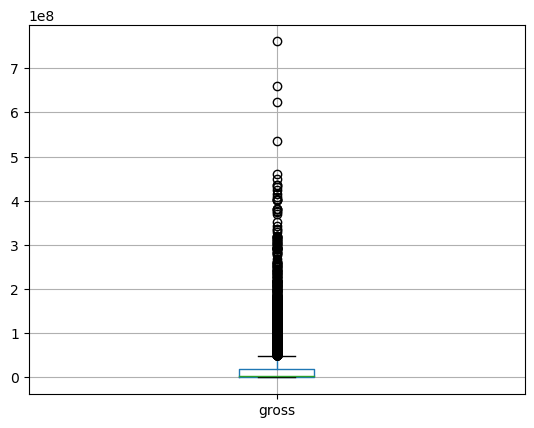

In [52]:
# optional: include your plotting code here
import matplotlib.pyplot as plt

df = pd.DataFrame(boxplot_result)
df.boxplot(column = ['gross'])
plt.show()

<!-- END QUESTION -->

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />

# Question 5: Joins

Joins are a powerful tool in database cleaning and analysis. They allow for the user to create useful tables and bring together information in a meaningful way. 

There are many types of joins: inner, outer, left, right, etc. Let's practice these in a special scenario. 

You are now working as a talent director and you need a list of all people who have been in `actor` roles and the number of movies in which they have acted. 

- Create a view called `number_movies`, which has columns `id`, `name`, `number` where `id` is the actor's id, `name` is the actor's name, and `number` is the number of movies they have acted in.
- Following your view, write a ``SELECT`` query to display the **top 10 actors** who have been in the most films.

**Note:** The `cast_sample` may include actors not included in `actor_sample` table. We still want to include these actors in our result by reference to their id. The `name` field can be NULL.

In [53]:
%%sql --save query_5 result_5 <<

DROP VIEW IF EXISTS number_movies;
CREATE VIEW number_movies AS (
    SELECT cs.person_id AS id, actor_sample.name AS name, COUNT(movie_id) AS number 
    FROM cast_sample AS cs
    LEFT JOIN actor_sample ON cs.person_id = actor_sample.id
    WHERE cs.role_id = 1
    GROUP BY cs.person_id, actor_sample.name
);

SELECT *
FROM number_movies
ORDER BY number DESC
LIMIT 10;

Running query in 'postgresql://jovyan@127.0.0.1:5432/imdb'

10 rows affected.

In [54]:
# Do not delete/edit this cell!
# You must run this cell before running the autograder.
query_5 = %sqlcmd snippets query_5
grading_util.save_results("result_5", query_5, result_5)
result_5

id,name,number
95397,"Barker, Bob",6853
515315,"Freeman, Morgan",5938
677696,"Hinnant, Skip",4697
1573853,"Trebek, Alex",4690
1362169,"Sajak, Pat",3937
1417394,"Shaffer, Paul",3546
911160,"Lima, Pedro",2911
900749,"Letterman, David",2895
487253,"Filipe, Guilherme",2861
356575,"Davidson, Doug",2760


In [55]:
grader.check("q5")

q5 results: All test cases passed!

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Congratulations! You have finished Project 1.

The below code prepares all the additional files needed for your submission, including:
* `results.zip`
* `proj1.pdf`

**Make sure to run this cell before exporting the final zip file with `grader.export()`!**

In [56]:
grading_util.prepare_submission_and_cleanup() 
!otter export -e latex proj1.ipynb proj1.pdf   # Export PDF

/srv/conda/envs/notebook/lib/python3.11/site-packages/nbconvert/utils/pandoc.py:51: RuntimeWarning: You are using an unsupported version of pandoc (2.12).
Your version must be at least (2.14.2) but less than (4.0.0).
Refer to https://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()


In [57]:
# Close SQL magic connection
%sql --close postgresql://127.0.0.1:5432/imdb

RuntimeError: Could not close connection because it was not found amongst these: ['postgresql://jovyan@127.0.0.1:5432/imdb']
If you need help solving this issue, send us a message: https://ploomber.io/community


## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

After you have run the cell below and generated the zip file, you can download your PDF <a href='hw01.pdf' download>here</a>.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True, files=['proj1.pdf', 'results.zip'])